## Домашняя работа №1
Вам предстоит:

Написать персептрон с двумя слоями. Реализовать форвард и бэквард пропогейшен



In [1]:
import numpy as np
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time

# Датасет

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

In [4]:
# фильтруем фичи (дата) по значению классификационных лэйблов (таргет), берем или цифру 3 или цифру 7
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
# тоже самое для тестового набора
test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

# необходимы препроцессинг лейблов, видимо не все значения имею тип integer, а нам нужен именно этот тип 
# функция лонг позволяет нам это сделать (self.long() is equivalent to self.to(torch.int64). See to())
train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [7]:
def relu(t):
    return np.maximum(t, 0)


def relu_deriv(t):
    return np.heaviside(t, 1)


def sigmoid(t):
    return 1 / (1 + np.exp(-t))


def sigmoid_deriv(x):
    return sigmoid(x) * (1.0 - sigmoid(x))


def to_full(y, n_classes):
    y_full = np.zeros((1, n_classes))
    y_full[0, y] = 1
    return y_full


eps = 1e-8
lr = 0.1
epochs = 5
batch_size = 128

input_dim = 784
hidden_dim = 128
output_dim = 1

w1 = np.random.rand(input_dim, hidden_dim) * 0.01
b1 = np.zeros(hidden_dim)
w2 = np.random.rand(hidden_dim, output_dim) * 0.01
b2 = np.zeros(output_dim)

losses = []

for n_epoch in range(epochs):
    print(f'Epoch: {n_epoch + 1}')

    for x, y in train_loader:
        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)

        ### forward ###
        z1 = x @ w1 + b1
        a1 = relu(z1)
        z2 = a1 @ w2 + b2    
        a2 = sigmoid(z2)

        #расчет энтропии с усреднением по размеру батча
        bce = -np.mean(y * np.log(a2 + eps) + (1 - y) * np.log(1 - a2 + eps))
        print(bce)
        
        ### backward ### 
        da2 = (a2 - y) / len(x)
        dw2 = a2.T @ da2 
        db2 = np.sum(da2)
        
        da1 = da2 @ (w2.T)
#         print(f"{a2.shape = } {da2.shape = } {dw2.shape = } {db2.shape = } {da1.shape = }")
        dw1 = x.T @ da1 
        db1 = np.sum(da1) 
        
        '''
        dLoss_dz2 = a2 - y
        dLoss_dw2 = a2.T @ (dLoss_dz * dLoss_dz2)
        dLoss_db2 = dLoss_dz2
        dLoss_dh1 = dLoss_dz2 @ w2.T
        dLoss_dz1 = dLoss_dh1 * relu_deriv(z1)
        dLoss_dw1 = x.T @ dLoss_dz1
        dLoss_db1 = np.ones_like(dLoss_dz1) @ dLoss_dz1
        print(dLoss_dz1.shape)
        '''
        
        ### gradient descent ###
        w1 -= lr * dw1
        b1 -= lr * db1
        w2 -= lr * dw2
        b2 -= lr * db2
        
        losses.append(bce)
        break

Epoch: 1
0.7318118972276318
Epoch: 2
0.7123194399003159
Epoch: 3
0.6878225700492838
Epoch: 4
0.6919877298849583
Epoch: 5
0.694051413121028


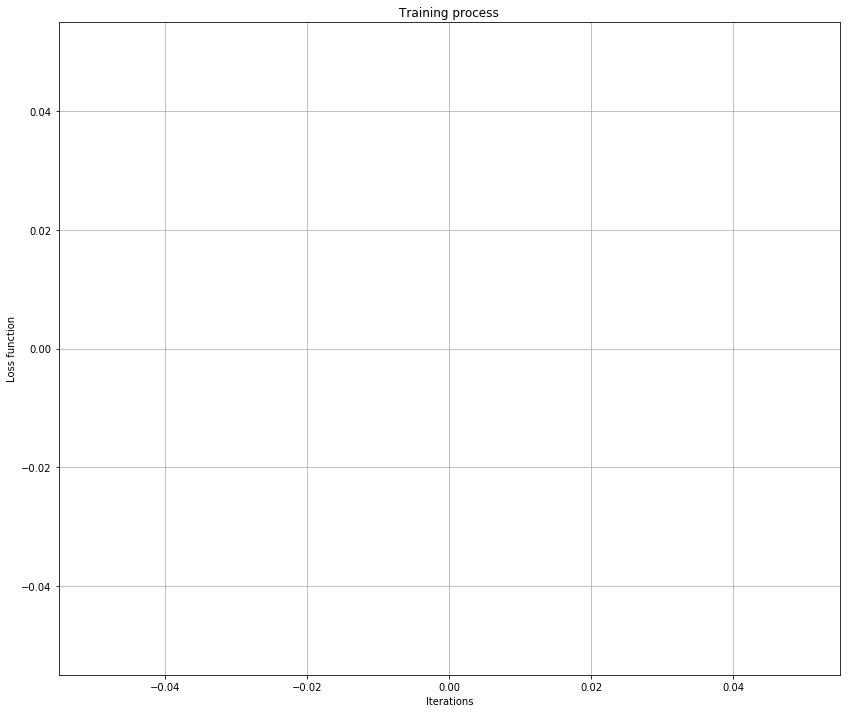

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');